# Climate Data Time-Series

You are again moving to another role, not at *The Weather Channel*, where you are ask to create a Weather Forecasting Model.

For that, you will be using *Jena Climate* dataset recorded by the *Max Planck Institute for Biogeochemistry*.

The dataset consists of 14 features such as temperature, pressure, humidity etc, recorded **once per 10 minutes**.

Location: Weather Station, Max Planck Institute for Biogeochemistry in Jena, Germany

Time-frame Considered: **Jan 10, 2009 - December 31, 2012**


Library Imports

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

### 1) Load your data
Your data can be found on the Deep Learning Module under a file named: climate_data_2009_2012.csv

In [25]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/climate_data_2009_2012.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2) Data engineering

You are given 3 lists:
- titles: Display names of your columns
- feature_keys: Names of the columns used as features
- colors: The color to use when ploting that column's value

In [26]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]



Let's look at the climate data:

In [27]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Define a function to show a plot of each column (using the respective color)

In [28]:

def show_raw_visualization(data, date_time_key):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


Display each column in a plot using above funciton:

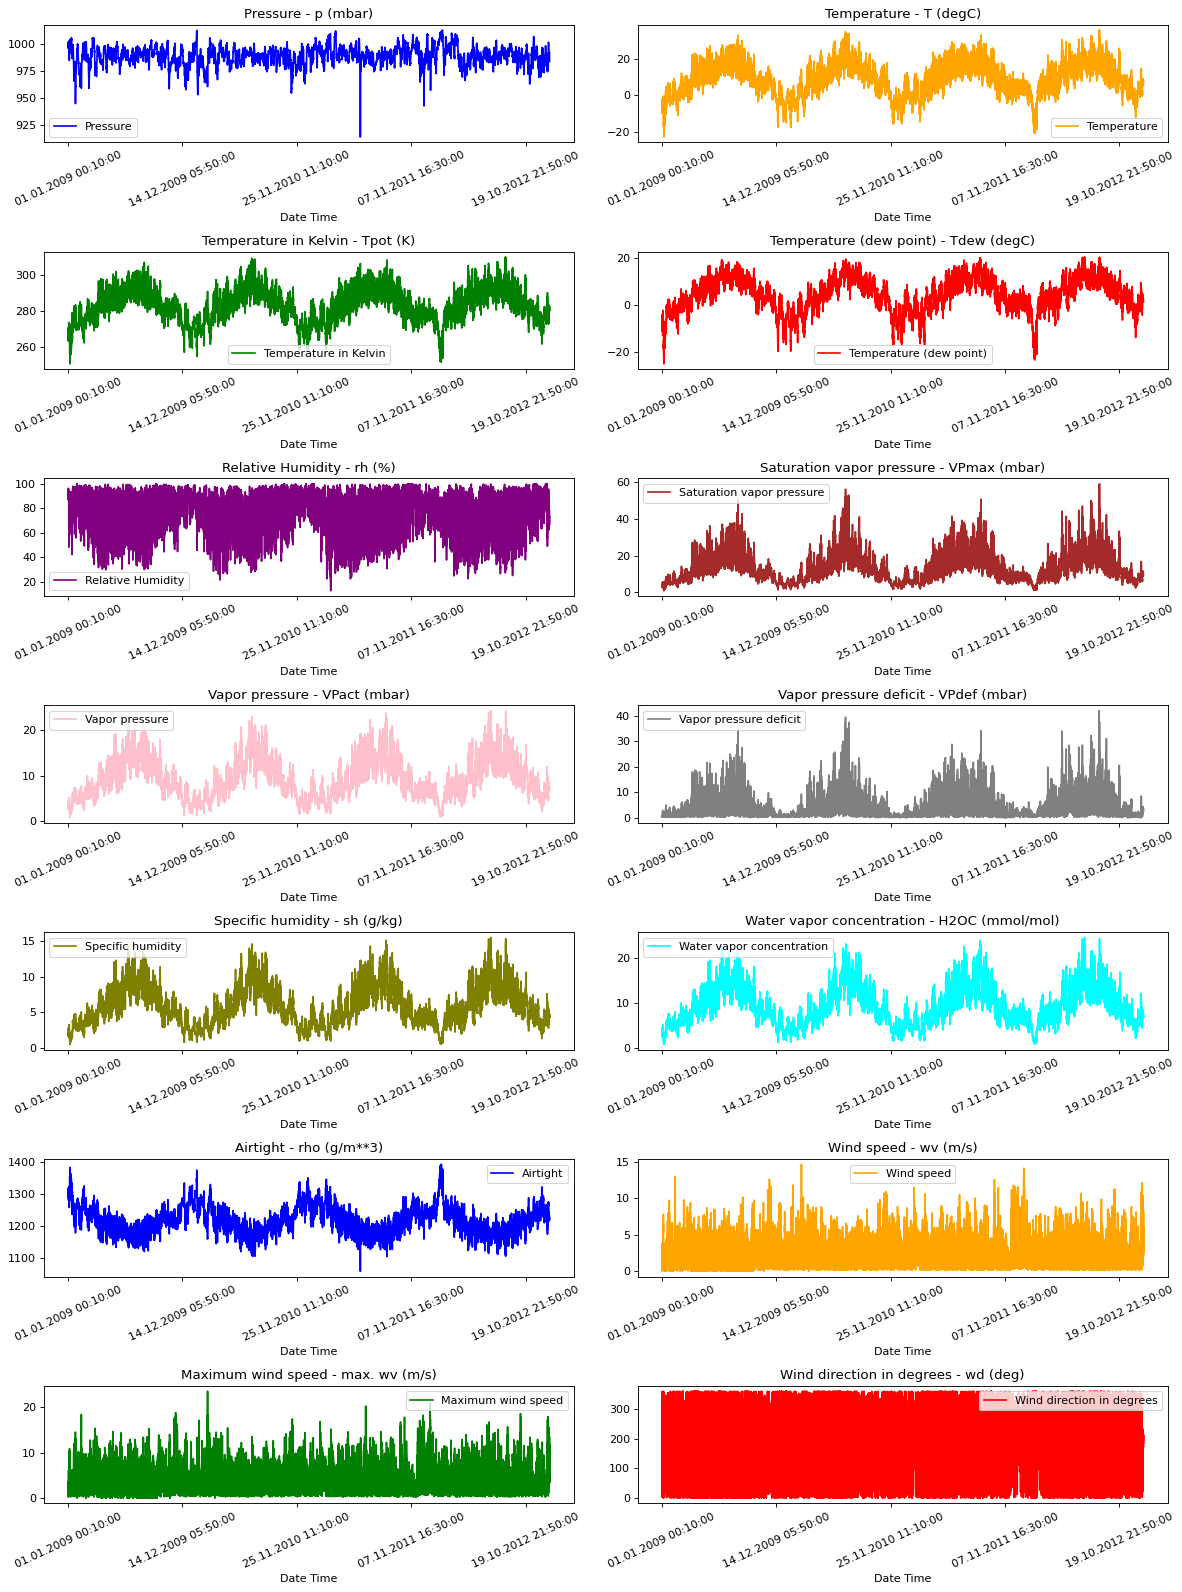

In [29]:
show_raw_visualization(df, "Date Time")

As you can see we have lots of data, this can be a challenge when we train our model, to resolve that we will reduce the resolution of our data, instead of having a climate signal each 10 minutes, we will have it each hour

- Add a new column to your dataframe with the Date Time information
- Name that column FormatedDateTime
- Convert that column into date time data type
- Set that column as the dataframe index
- Regroup data to be each 1 hour instead of each 10 minutes
- Save the grouped data into a dataframe called df_resampled
- Remove the FormatedDateTime as the index.
- Show the top 5 rows of df_resampled

In [30]:
df['FormatedDateTime'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df = df.set_index('FormatedDateTime')
df_resampled = df[feature_keys].resample('H').mean()
df_resampled = df_resampled.reset_index()

df_resampled.head()

<ipython-input-30-e61db8939877>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df[feature_keys].resample('H').mean()


,FormatedDateTime,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 00:00:00,996.528000,-8.304000,265.118000,-9.120000,93.780000,3.260000,3.058000,0.202000,1.910000,3.068000,1309.196000,0.520000,1.002000,174.460000
1,2009-01-01 01:00:00,996.525000,-8.065000,265.361667,-8.861667,93.933333,3.323333,3.121667,0.201667,1.951667,3.133333,1307.981667,0.316667,0.711667,172.416667
2,2009-01-01 02:00:00,996.745000,-8.763333,264.645000,-9.610000,93.533333,3.145000,2.940000,0.201667,1.836667,2.950000,1311.816667,0.248333,0.606667,196.816667
3,2009-01-01 03:00:00,996.986667,-8.896667,264.491667,-9.786667,93.200000,3.111667,2.898333,0.210000,1.811667,2.906667,1312.813333,0.176667,0.606667,157.083333
4,2009-01-01 04:00:00,997.158333,-9.348333,264.026667,-10.345000,92.383333,3.001667,2.775000,0.231667,1.733333,2.780000,1315.355000,0.290000,0.670000,150.093333


Let's look at our fields again

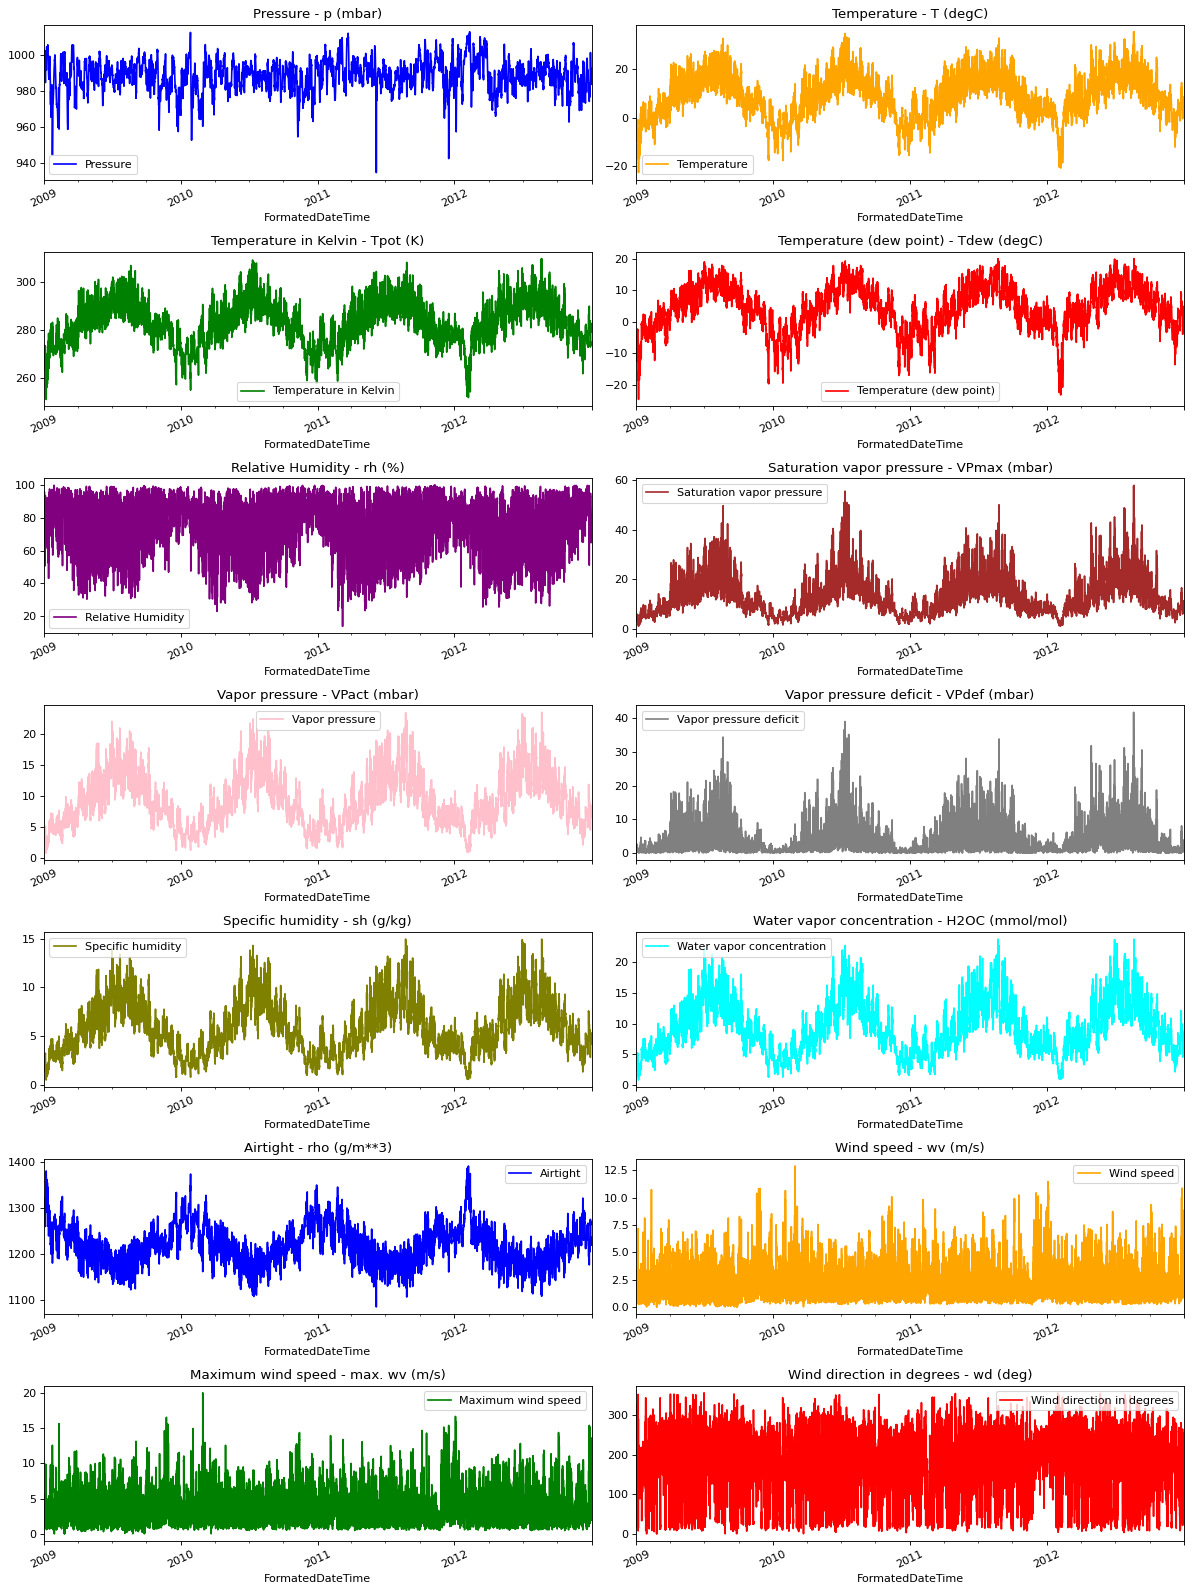

In [31]:
show_raw_visualization(df_resampled, "FormatedDateTime")

### 3) Data Split: Train and Evaluation datasets.

- We are tracking data from past 120 timestamps (120 hours = 5 days).
- This data will be used to predict the temperature after 12 timestamps (12 hours).
- Since every feature has values with varying ranges, we do normalization to confine feature values to a range of [0, 1] before training a neural network.
- We do this by subtracting the mean and dividing by the standard deviation of each feature in the *normalize* function
- The model is shown data for first 5 days i.e. 120 observations, that are sampled every hour.
- The temperature after 12 hours observation will be used as a label.


In [32]:
# 70% of the data will be used for training, the rest for testing
split_fraction = 0.7
# The number of samples is the number of rows in the data
number_of_samples = df_resampled.shape[0]
# The size in rows of the split dataset
train_split = int(split_fraction * int(number_of_samples))

# Number of samples in the past used to predict the future
past = 120
# Number of samples in the future to predict (the value in the 72nd hour is our label)
future = 12
# Learning rate parameter for the Adam optimizer
learning_rate = 0.001
# Batch size for the model training
batch_size = 256
# Number of epochs for the model training
epochs = 10

# Another way to normalize the data (all columns in the same range)
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

- Let's select the following parameters as our features:
   - Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed

- Set the column FormatedDateTime as the index of our dataframe.
   - This is important since now, FormatedDateTime is used as our datetime field and not as a Feature field

- Normalize all fields

- Generate two datasets:
   - train_data: Train dataset with our normalized fields
   - val_data: Validation dataset

In [33]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df_resampled[selected_features]
features.index = df_resampled["FormatedDateTime"]
print(features.head())

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
print(features.head())

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed
                       p (mbar)  T (degC)  VPmax (mbar)  VPdef (mbar)  \
FormatedDateTime                                                        
2009-01-01 00:00:00  996.528000 -8.304000      3.260000      0.202000   
2009-01-01 01:00:00  996.525000 -8.065000      3.323333      0.201667   
2009-01-01 02:00:00  996.745000 -8.763333      3.145000      0.201667   
2009-01-01 03:00:00  996.986667 -8.896667      3.111667      0.210000   
2009-01-01 04:00:00  997.158333 -9.348333      3.001667      0.231667   

                     sh (g/kg)  rho (g/m**3)  wv (m/s)  
FormatedDateTime                                        
2009-01-01 00:00:00   1.910000   1309.196000  0.520000  
2009-01-01 01:00:00   1.951667   1307.981667  0.316667  
2009-01-01 02:00:00   1.836667   1311.816667  0.248333  
2009-01-01 03:00:00   1.811667   1312.813333  0.176667  
200

Now, here we need to set our Label Dataset.

- We want to use the last 5 days of data, to predict the next 12 hours
- This means that our label starts at the 12th hour after the history data.
   - [.......................... **.** ]
   - -----Start----->
- And it will end at the end of our train dataset size.
   - <-------- Train ---------> <--- Test --->
   - [.................................................**|**...........]
   - ----------End---------->

In [34]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

step = 1
sequence_length = past

The *timeseries_dataset_from_array* function takes in a sequence of data-points gathered at equal intervals, along with time series parameters such as length of the sequences/windows, spacing between two sequence/windows, etc., to produce batches of sub-timeseries inputs and targets sampled from the main timeseries.

- Input data (hour features) = x_train
- The **corresponding** value of the temperature 12 hours into the future = y_train
- Since we want to use 5 days of data to predict the future temperature then: sequence_length = 120
- Since we want to sample every hour then: sampling_rate = 1
- Let's use a common batch size of 256 (variable above)

In [35]:
import keras

In [36]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

Now let's prepare our validation dataset:

- The validation dataset must not contain the last 120+12 rows as we won't have label data for those records, hence these rows must be subtracted from the end of the data.
- The validation label dataset must start from 120+12 after train_split, hence we must add past + future to label_start.

In [37]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 7)
Target shape: (256, 1)


### 4) Define and Compile your model:
- An input layer
- A Long Short-Term Memory Hidden Layer with 32 units. LSTM is a type of recurrent neural network layer that is well-suited for time series data.
- An output Dense Layer (Linear Activation function)

In [38]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 120, 7)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,153 (20.13 KB)

 Trainable params: 5,153 (20.13 KB)

 Non-trainable params: 0 (0.00 B)

### 5) Train your model:

Specify the file path where the model's weights will be saved with:
`path_checkpoint = "model_checkpoint.weights.h5"`

We want to add a callback to stop training when a monitored metric stops improving:
`es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)`

Train the model using Fit


In [39]:
path_checkpoint = "model_checkpoint.weights.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.6279
Epoch 1: val_loss improved from inf to 0.24185, saving model to model_checkpoint.weights.h5
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 155ms/step - loss: 0.6227 - val_loss: 0.2419
Epoch 2/10
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.2022
Epoch 2: val_loss improved from 0.24185 to 0.18934, saving model to model_checkpoint.weights.h5
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - loss: 0.2021 - val_loss: 0.1893
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.1636
Epoch 3: val_loss improved from 0.18934 to 0.15954, saving model to model_checkpoint.weights.h5
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 217ms/step - loss: 0.1635 - val_loss: 0.1595
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 0.1430
Epoch 4: val_loss improved from 0.15954 to 0.15265, saving model to model_checkpoint.weights.h5
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 240ms/step - loss: 0.1430 - val_loss: 0.1527
Epoch 5/10
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/s

Plot the results of your training:

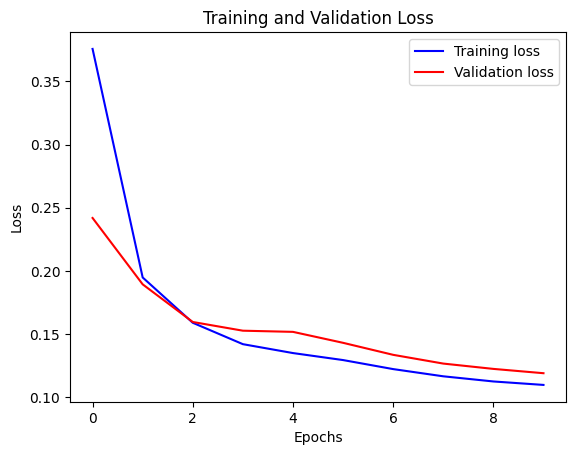

In [40]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

Make 5 predictions and display the predicted value

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


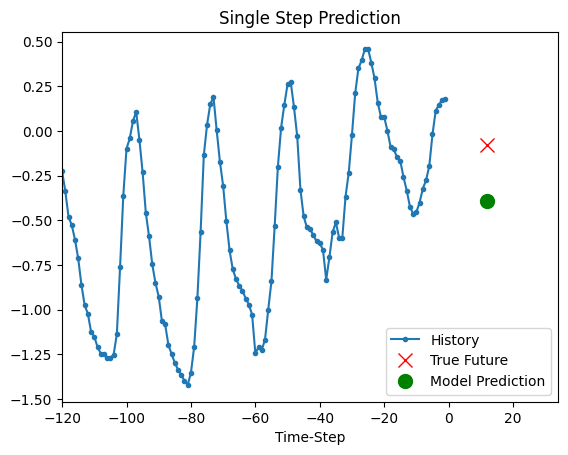

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


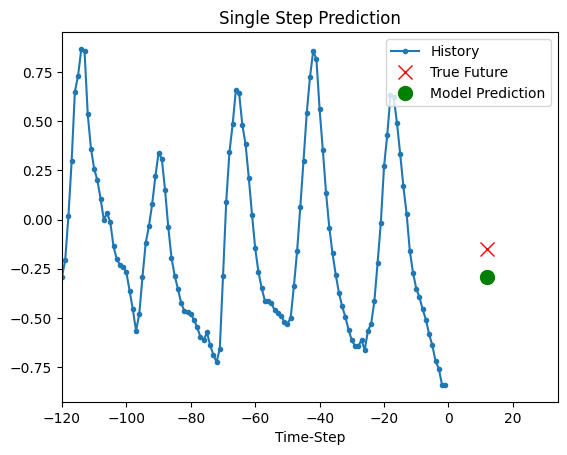

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


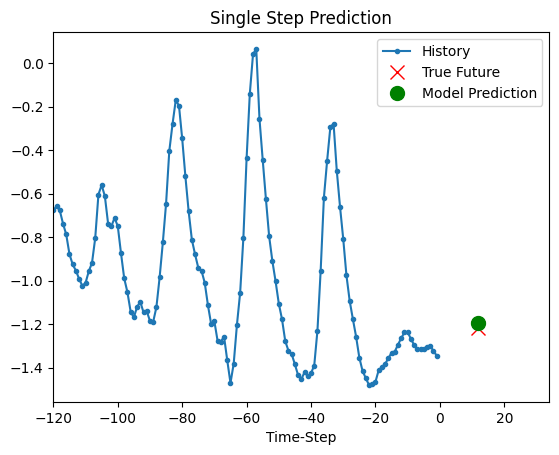

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


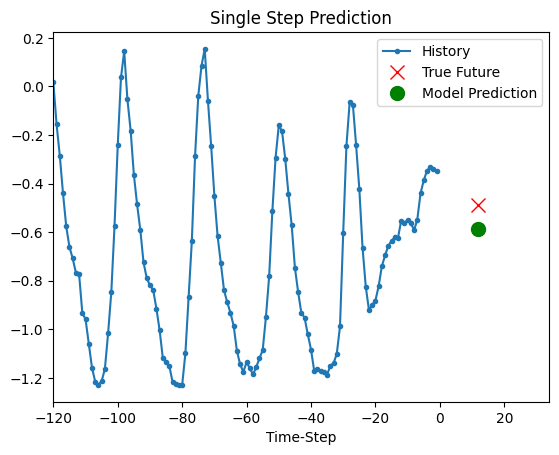

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


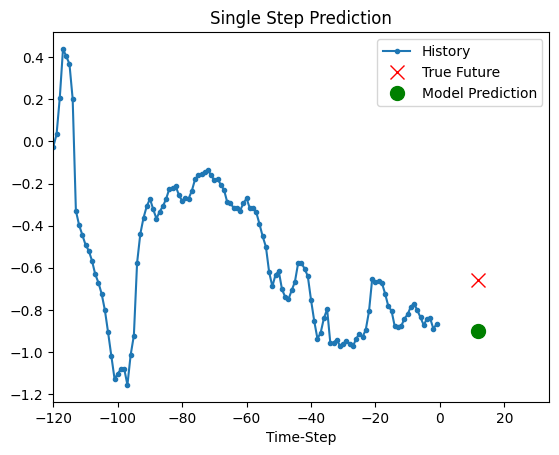

In [41]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

Now make a Time Series Forecasting where using the last 3 days you will predict the weather in the next 3 hours.

In [51]:
# Data engineering and data split

past = 72
future = 3
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
train_data = features.loc[0:train_split - 1]
val_data = features.loc[train_split:]
start = past + future
end = start + train_split
x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]
sequence_length = past
step = 1
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)
x_end = len(val_data) - past - future
label_start = train_split + past + future
x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:label_start + future][[1]].values
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,

)

# Creating and compiling the model

inputs = keras.layers.Input(shape=(72, inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(3)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

# Fitting the model
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 72, 7)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 32)                  │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,219 (20.39 KB)

 Trainable params: 5,219 (20.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.9155
Epoch 1: val_loss improved from 0.06306 to 0.01086, saving model to model_checkpoint.weights.h5
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - loss: 0.9073 - val_loss: 0.0109
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.2266
Epoch 2: val_loss did not improve from 0.01086
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 0.2265 - val_loss: 0.0467
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.1712
Epoch 3: val_loss did not improve from 0.01086
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.1712 - val_loss: 0.1089
Epoch 4/10
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.1372
Epoch 4: val_loss did not improve from 0.01086
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - loss: 0.1370 - val_loss: 0.1396
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1052
Epoch 5: val_loss did not improve from 0.01086
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - loss: 0.1052 - val_loss: 0.2873
Epoch 6/10
96

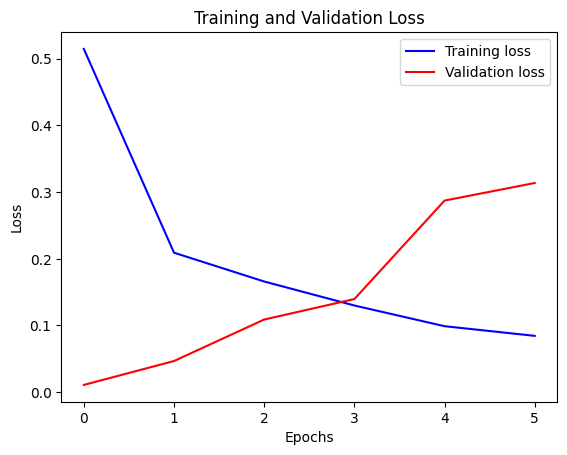

In [59]:
visualize_loss(history, "Training and Validation Loss")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


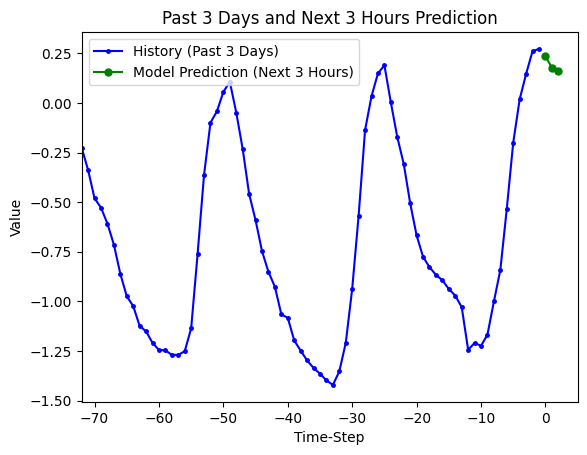

In [58]:
def plot_history_and_predictions(history, predictions, title):
    history_steps = list(range(-len(history), 0))
    future_steps = list(range(0, len(predictions)))

    plt.title(title)

    plt.plot(history_steps, history.flatten(), 'b.-', markersize=5, label="History (Past 3 Days)")


    plt.plot(future_steps, predictions.flatten(), 'go-', markersize=5, label="Model Prediction (Next 3 Hours)")

    plt.legend()

    plt.xlim([history_steps[0], future_steps[-1] + 3])

    plt.xlabel("Time-Step")
    plt.ylabel("Value")
    plt.show()

for x, _ in dataset_val.take(5):  # x contains past 72 hours of data
    prediction = model.predict(x)

    plot_history_and_predictions(x[0][:, 1].numpy(), prediction[0], "Past 3 Days and Next 3 Hours Prediction")


As we can see, it seems the model is adequately predicting the next 3 elements, following the trends from the previous highs and lows. Our lowest validation loss was 0.01086 which is pretty good.